In [5]:
import gym
import matplotlib.pyplot as plt
import numpy as np
from gym_minigrid.wrappers import RGBImgPartialObsWrapper
from gym_minigrid.minigrid import Grid, Wall, Goal, Lava
import random

class CustomMiniGridEnv(gym.Env):
    def __init__(self, grid_size=4):
        super(CustomMiniGridEnv, self).__init__()

        self.grid_size = grid_size
        self.action_space = gym.spaces.Discrete(4)
        self.observation_space = gym.spaces.Box(low=0, high=255, shape=(grid_size * 10, grid_size * 10, 3), dtype=np.uint8)
        self.colors = {
            Wall: [255, 255, 0],   # Wall color (Yellow)
            Lava: [255, 0, 0],     # Lava (Pit) color (Red)
            Goal: [0, 255, 0],     # Goal color (Green)
        }
        
        self.reset()

    def reset(self):
        self.grid = Grid(width=self.grid_size, height=self.grid_size)
        self.player_pos = self.generate_random_position([])
        self.wall_pos = self.generate_random_position([self.player_pos])
        self.goal_pos = self.generate_random_position([self.player_pos, self.wall_pos])
        self.pit_pos = self.generate_random_position([self.player_pos, self.wall_pos, self.goal_pos])

        self.grid.set(*self.wall_pos, Wall())
        self.grid.set(*self.pit_pos, Lava())
        self.grid.set(*self.goal_pos, Goal())

        self.reward_counter = 0
        self.reward = 0
        self.step_counter = 0

        return self.get_observation()

    def step(self, action):
        self.perform_action(action)
        self.step_counter += 1

        done = False
        if self.reward == 10 or self.step_counter > 15 or self.reward == -10:
            done = True

        return self.get_observation(), self.reward, done, {}

    def render(self, mode='human'):
        plt.imshow(self.grid_img)
        plt.axis('off')
        plt.show()

    def generate_random_position(self, existing_positions):
        while True:
            pos = (random.randint(0, self.grid_size - 1), random.randint(0, self.grid_size - 1))
            if pos not in existing_positions:
                return pos

    def perform_action(self, action):
        # Clear the previous player position
        self.grid_img[self.player_pos[0] * 10: (self.player_pos[0] + 1) * 10, self.player_pos[1] * 10: (self.player_pos[1] + 1) * 10] = [0, 0, 0]

        # Update the player position based on the action
        if action == 0:  # Up
            new_pos = (max(self.player_pos[0] - 1, 0), self.player_pos[1])
        elif action == 1:  # Down
            new_pos = (min(self.player_pos[0] + 1, self.grid_size - 1), self.player_pos[1])
        elif action == 2:  # Left
            new_pos = (self.player_pos[0], max(self.player_pos[1] - 1, 0))
        elif action == 3:  # Right
            new_pos = (self.player_pos[0], min(self.player_pos[1] + 1, self.grid_size - 1))

        # Check if the new position is a wall
        if isinstance(self.grid.get(*new_pos), Wall):
            new_pos = self.player_pos  # Stay in the same position if hitting a wall

        # Check if the new position is lava
        if isinstance(self.grid.get(*new_pos), Lava):
            self.reward = -10
        elif isinstance(self.grid.get(*new_pos), Goal):
            self.reward = 10
        else:
            self.reward = -1

        # Update the player position
        self.player_pos = new_pos

        # Highlight the new player position
        self.grid_img[self.player_pos[0] * 10: (self.player_pos[0] + 1) * 10, self.player_pos[1] * 10: (self.player_pos[1] + 1) * 10] = [0, 0, 255]

        # Update the reward counter
        self.reward_counter += self.reward

#         # Print the sum of rewards and the current player position's reward
#         print("Total Reward:", self.reward_counter)
#         print("Current Position's Reward:", self.reward)
#         print("Action Done:", action)

    def get_observation(self):
        self.grid_img = np.zeros((self.grid_size * 10, self.grid_size * 10, 3), dtype=np.uint8)

        # Update the grid image with colors
        for row in range(self.grid_size):
            for col in range(self.grid_size):
                cell_type = self.grid.get(row, col).__class__
                self.grid_img[row * 10: (row + 1) * 10, col * 10: (col + 1) * 10] = self.colors.get(cell_type, [0, 0, 0])

        # Highlight the wall, pit, goal, and player positions
        self.grid_img[self.wall_pos[0] * 10: (self.wall_pos[0] + 1) * 10, self.wall_pos[1] * 10: (self.wall_pos[1] + 1) * 10] = [255, 255, 0]
        self.grid_img[self.pit_pos[0] * 10: (self.pit_pos[0] + 1) * 10, self.pit_pos[1] * 10: (self.pit_pos[1] + 1) * 10] = [255, 0, 0]
        self.grid_img[self.goal_pos[0] * 10: (self.goal_pos[0] + 1) * 10, self.goal_pos[1] * 10: (self.goal_pos[1] + 1) * 10] = [0, 255, 0]
        self.grid_img[self.player_pos[0] * 10: (self.player_pos[0] + 1) * 10, self.player_pos[1] * 10: (self.player_pos[1] + 1) * 10] = [0, 0, 255]

        return self.grid_img
    
    def render_np(self):
        player_slice = np.zeros((self.grid_size, self.grid_size), dtype=np.uint8)
        player_slice[self.player_pos] = 1

        goal_slice = np.zeros((self.grid_size, self.grid_size), dtype=np.uint8)
        goal_slice[self.goal_pos] = 1

        pit_slice = np.zeros((self.grid_size, self.grid_size), dtype=np.uint8)
        pit_slice[self.pit_pos] = 1

        wall_slice = np.zeros((self.grid_size, self.grid_size), dtype=np.uint8)
        wall_slice[self.wall_pos] = 1

        return np.stack([player_slice, goal_slice, pit_slice, wall_slice], axis=0)

Game 1
--------


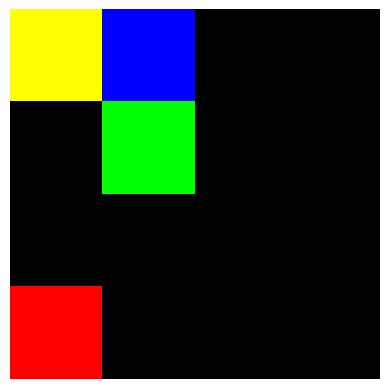

Step: 1


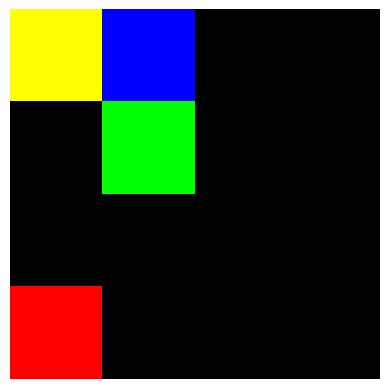

Game Result: Win
Game 2
--------


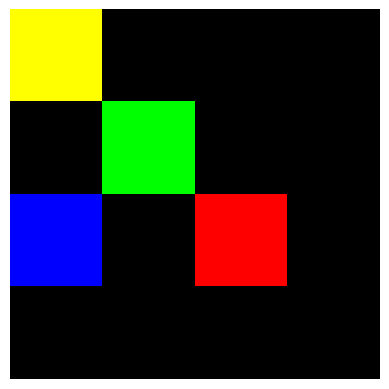

Step: 1


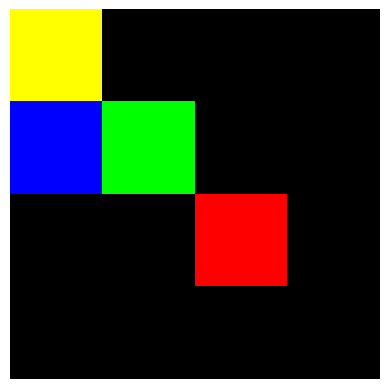

Step: 2


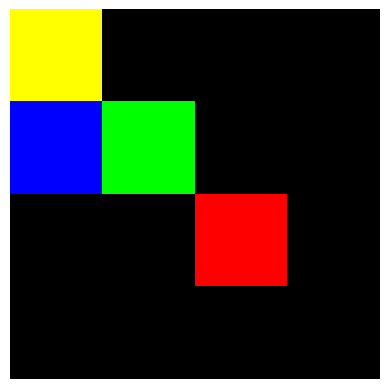

Step: 3


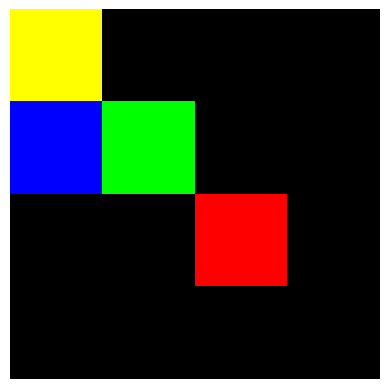

Game Result: Win
Game 3
--------


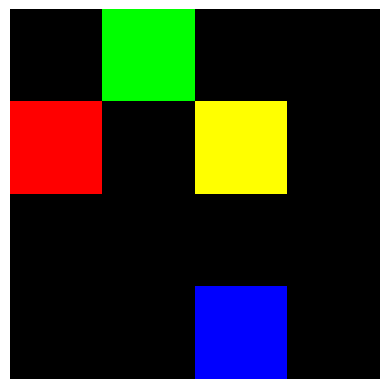

Step: 1


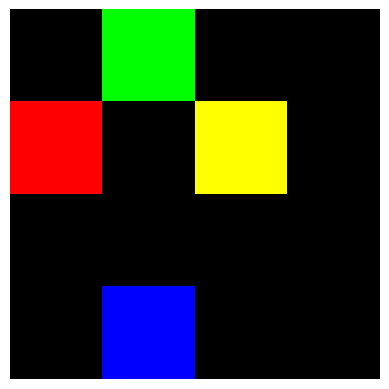

Step: 2


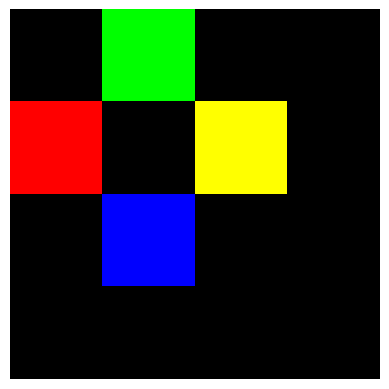

Step: 3


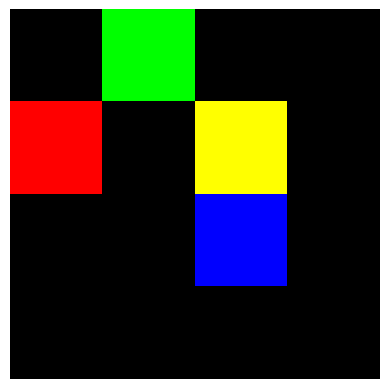

Step: 4


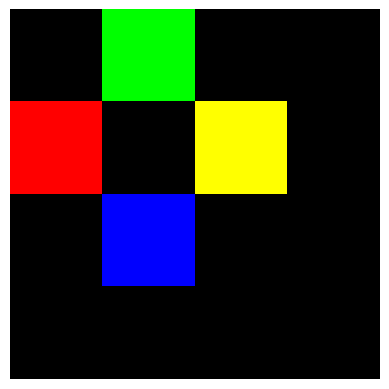

Step: 5


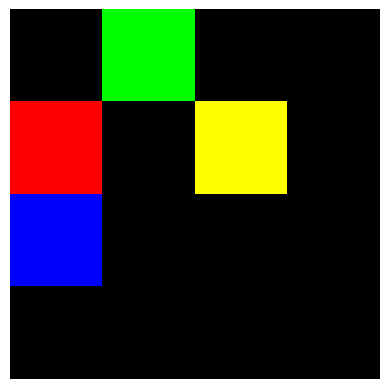

Step: 6


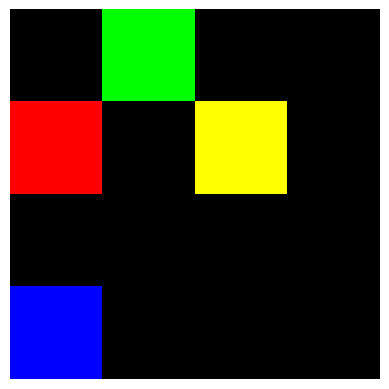

Step: 7


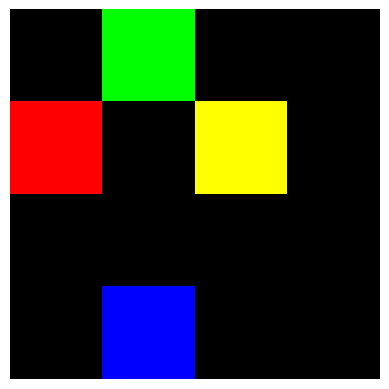

Step: 8


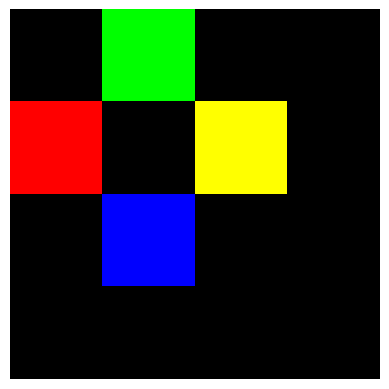

Step: 9


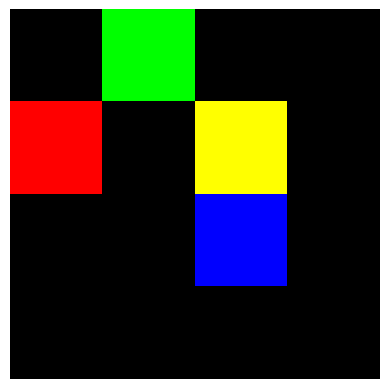

Step: 10


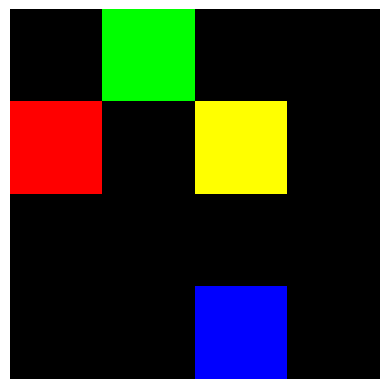

Step: 11


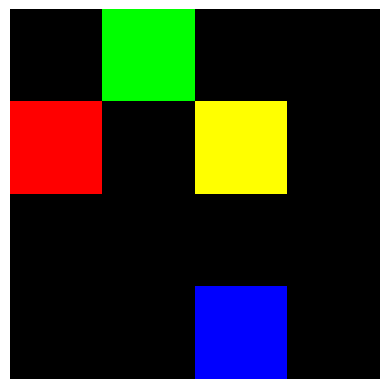

Step: 12


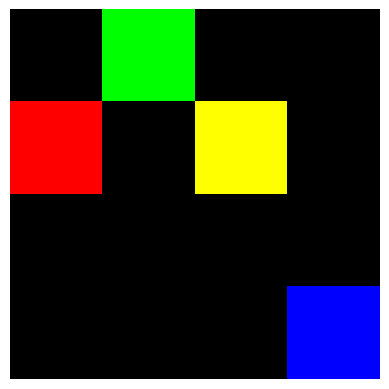

Step: 13


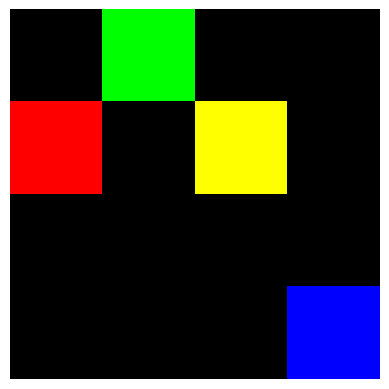

Step: 14


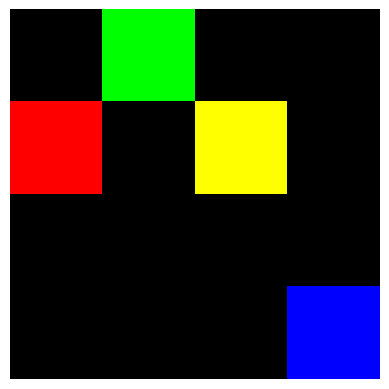

Step: 15


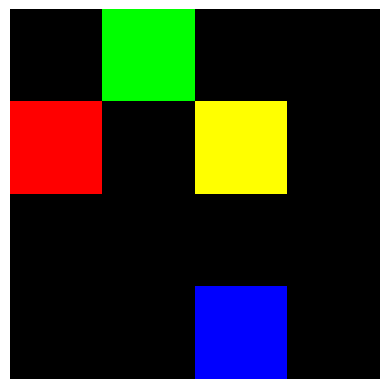

Game Result: Loss
Game 4
--------


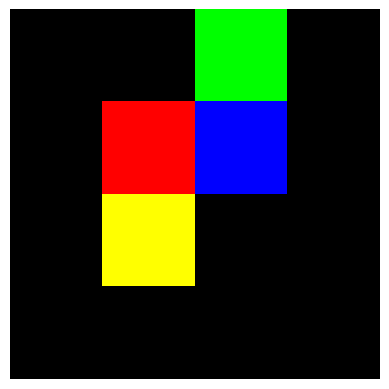

Game Result: Loss
Game 5
--------


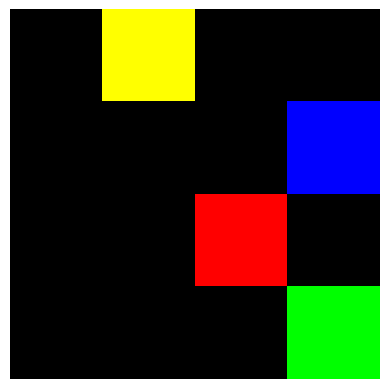

Step: 1


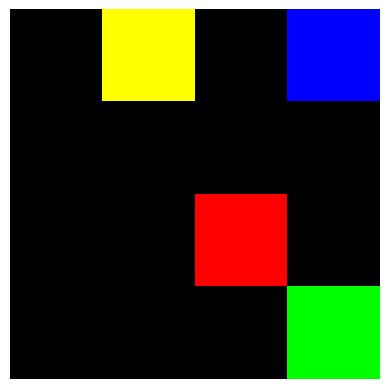

Step: 2


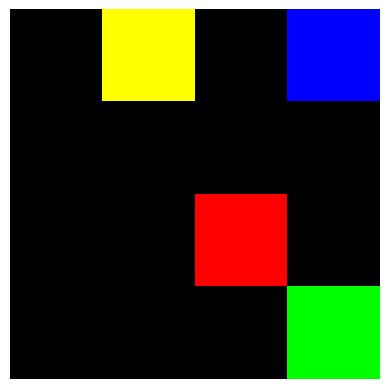

Step: 3


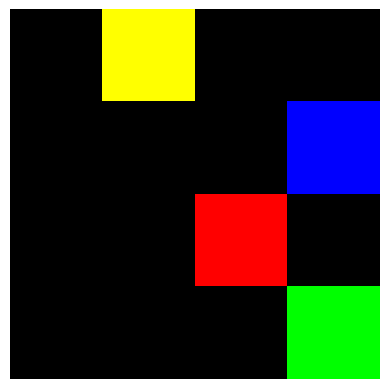

Step: 4


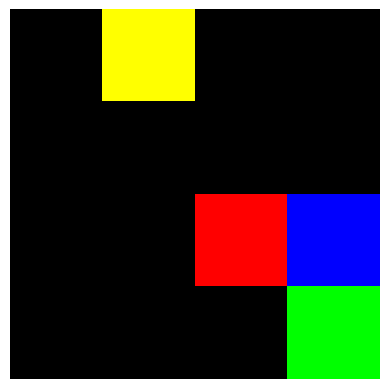

Game Result: Loss
Game 6
--------


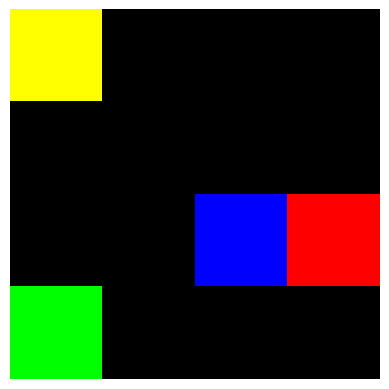

Step: 1


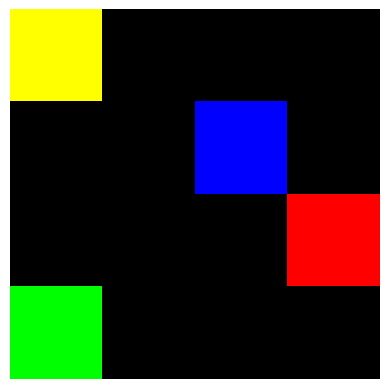

Step: 2


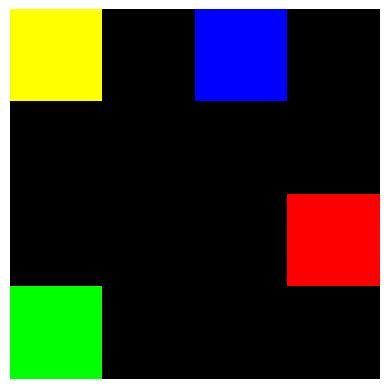

Step: 3


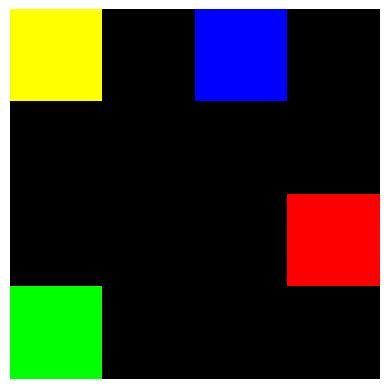

Step: 4


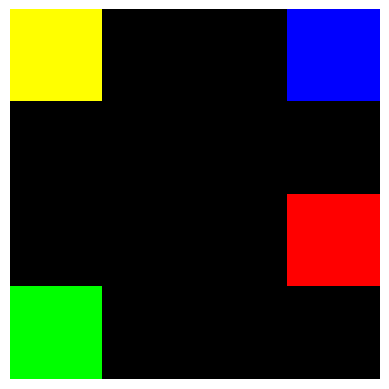

Step: 5


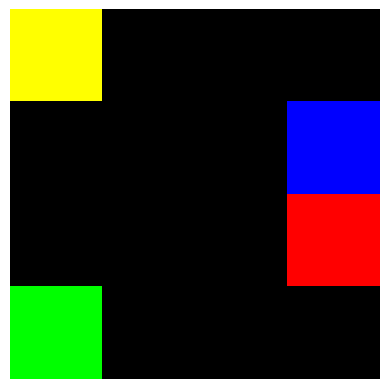

Step: 6


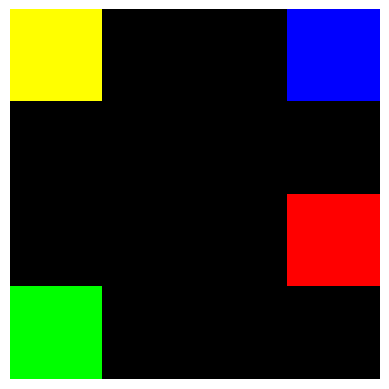

Step: 7


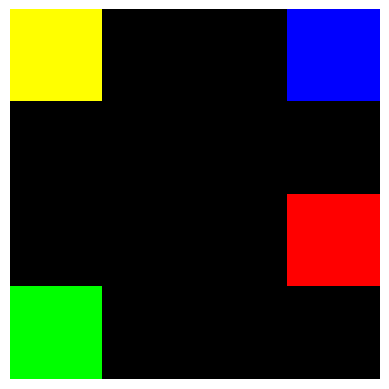

Step: 8


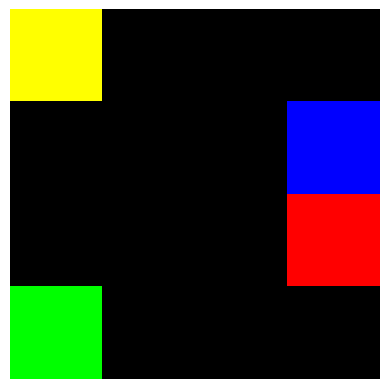

Step: 9


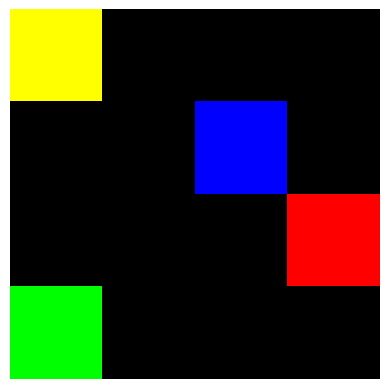

Step: 10


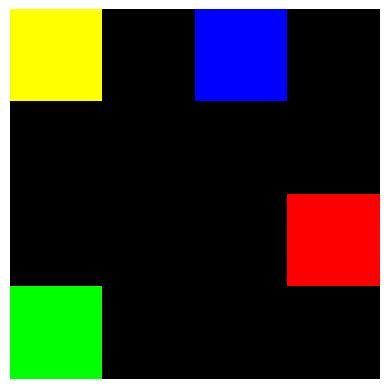

Step: 11


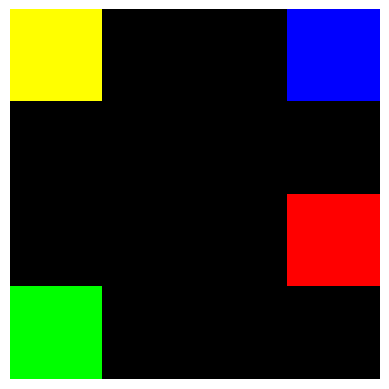

Step: 12


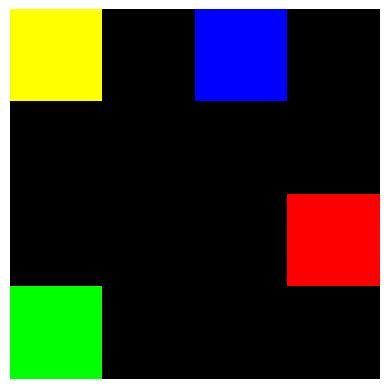

Step: 13


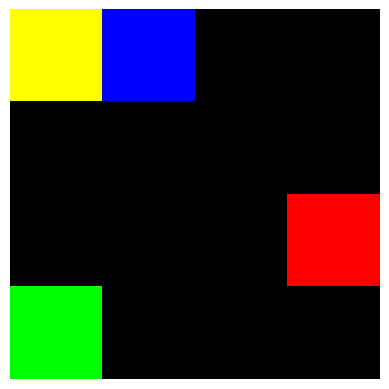

Step: 14


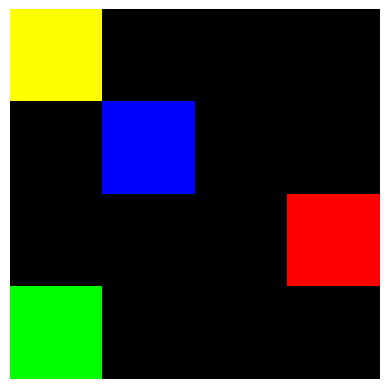

Step: 15


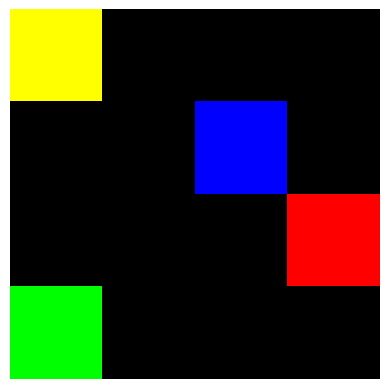

Game Result: Loss
Game 7
--------


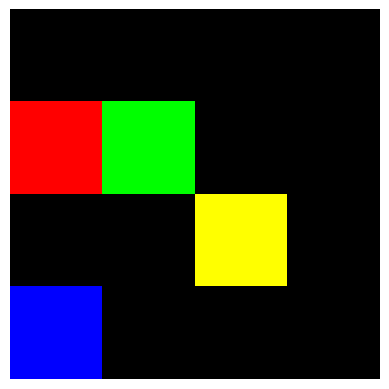

Step: 1


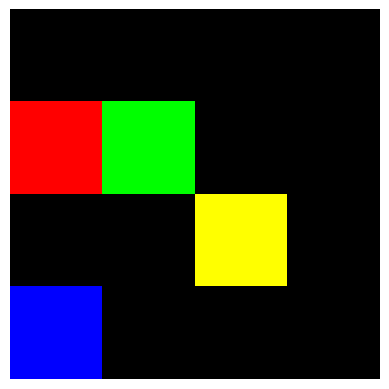

Step: 2


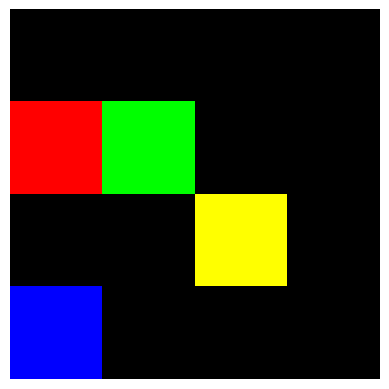

Step: 3


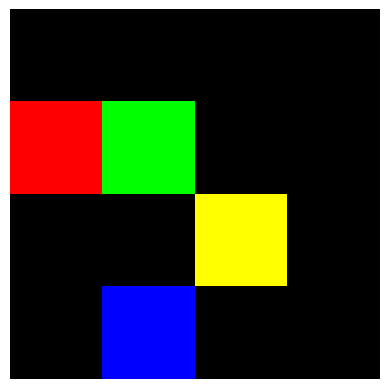

Step: 4


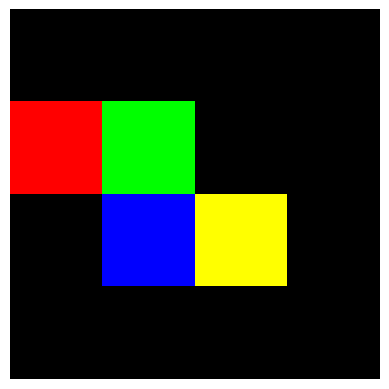

Game Result: Win
Game 8
--------


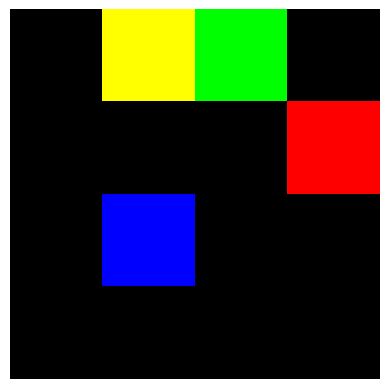

Step: 1


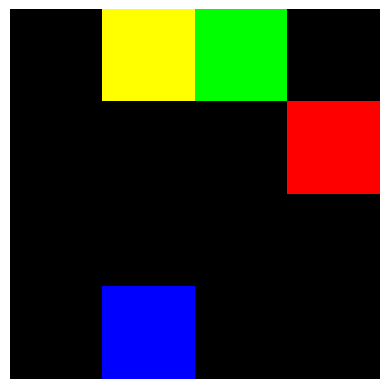

Step: 2


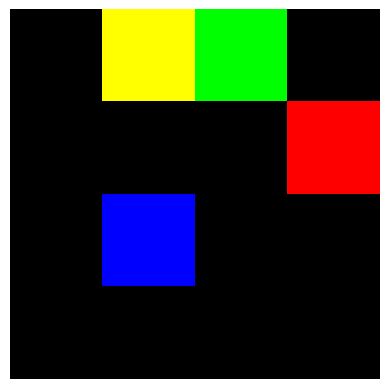

Step: 3


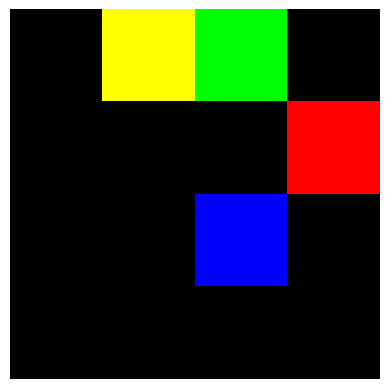

Step: 4


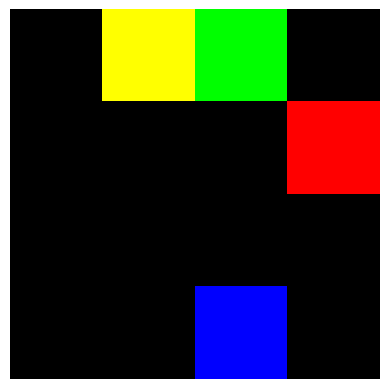

Step: 5


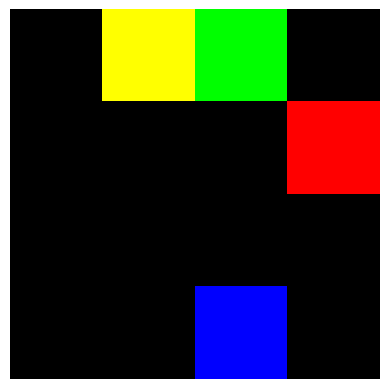

Step: 6


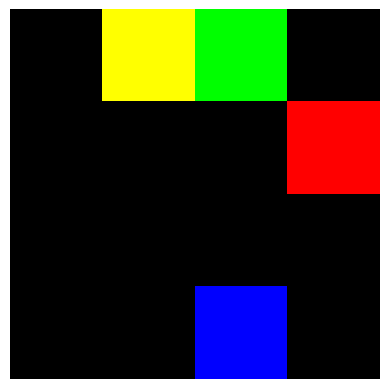

Step: 7


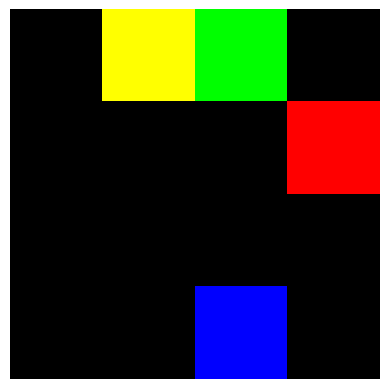

Step: 8


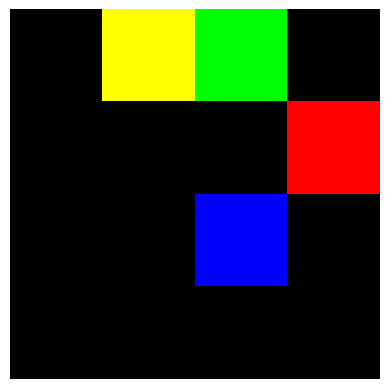

Step: 9


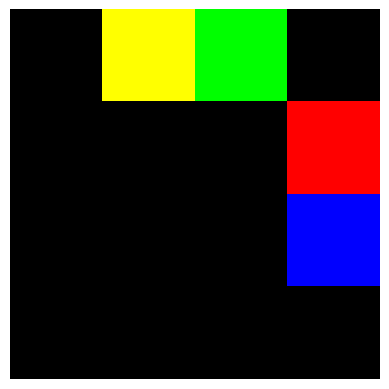

Step: 10


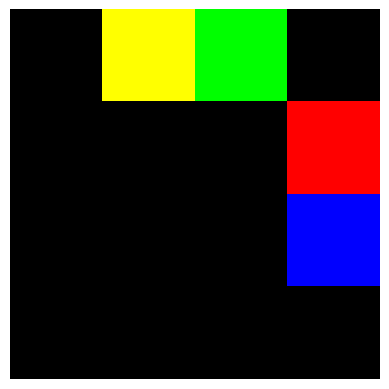

Step: 11


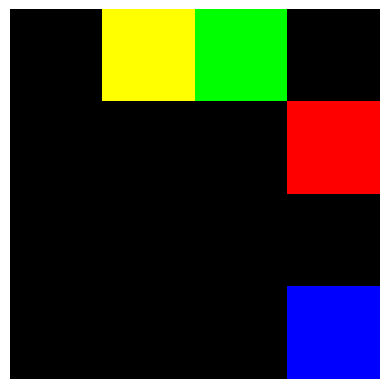

Step: 12


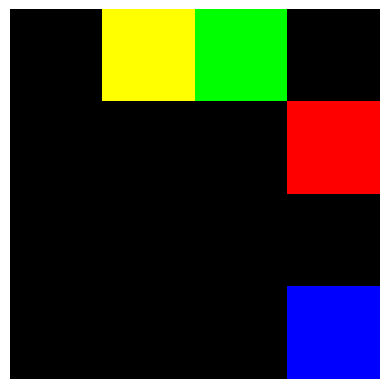

Step: 13


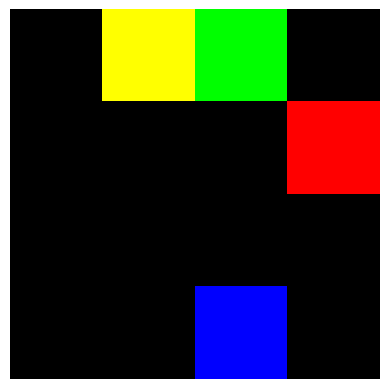

Step: 14


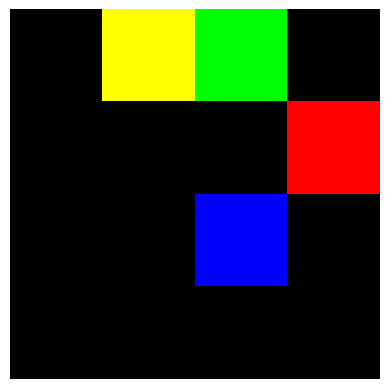

Step: 15


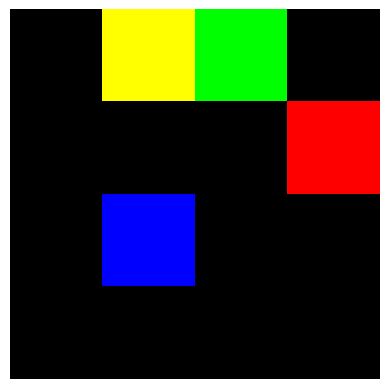

Game Result: Loss
Game 9
--------


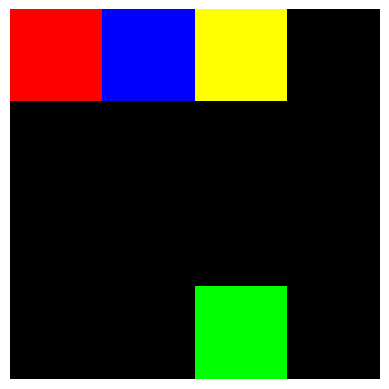

Step: 1


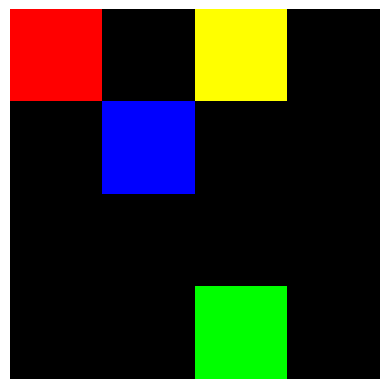

Step: 2


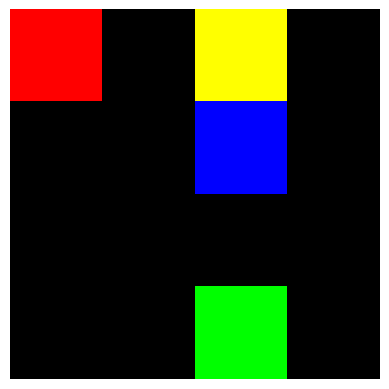

Step: 3


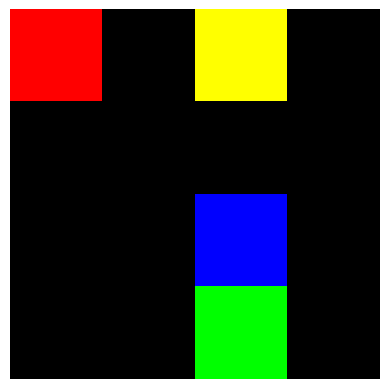

Game Result: Win
Game 10
--------


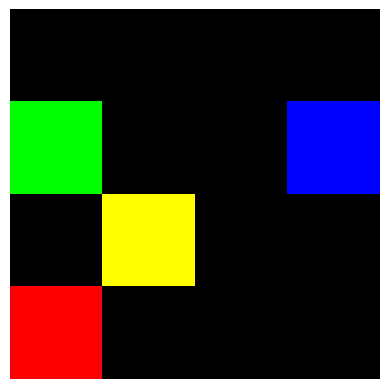

Step: 1


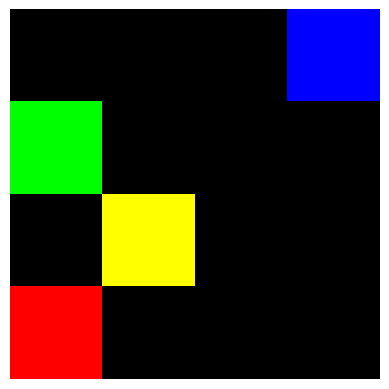

Step: 2


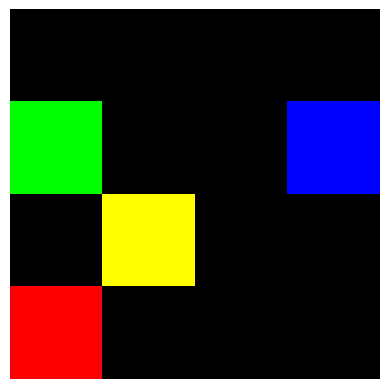

Step: 3


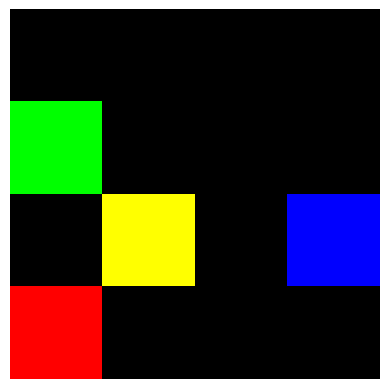

Step: 4


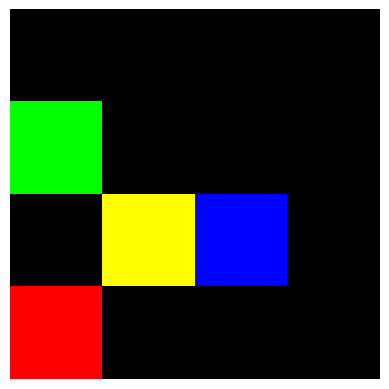

Step: 5


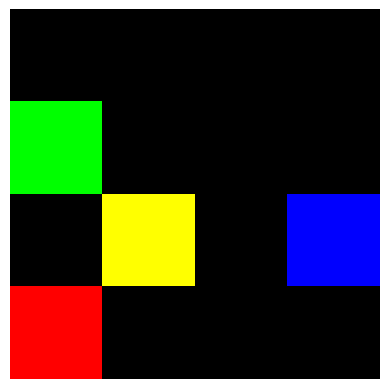

Step: 6


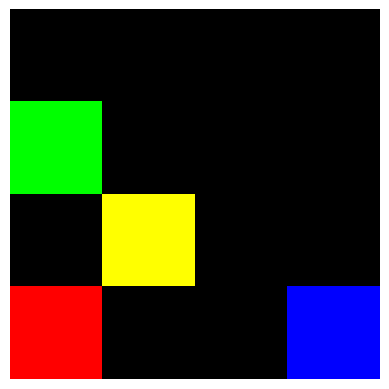

Step: 7


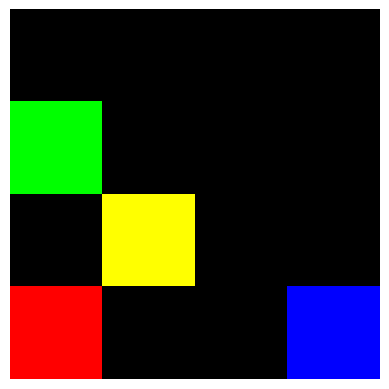

Step: 8


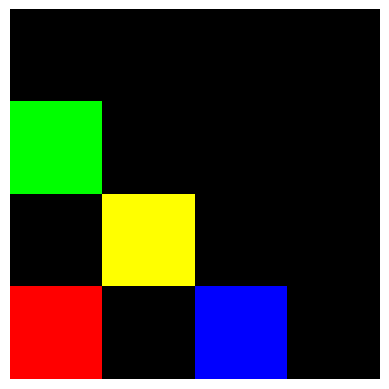

Step: 9


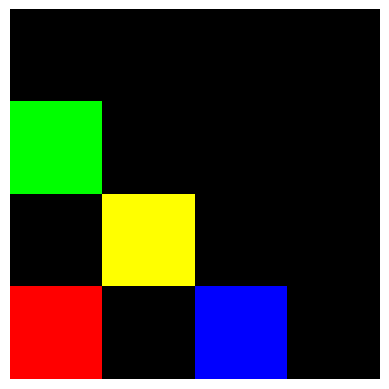

Step: 10


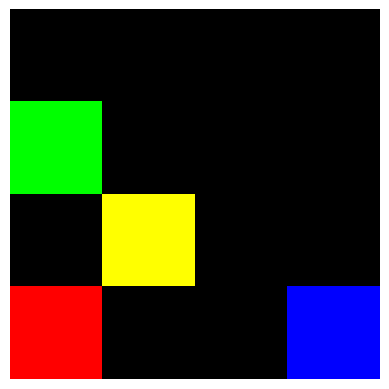

Step: 11


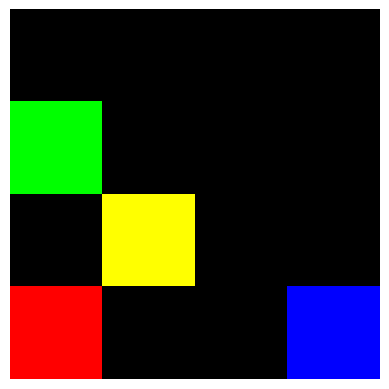

Step: 12


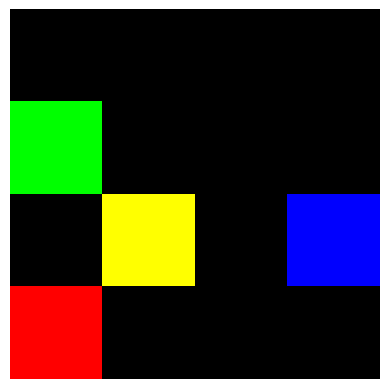

Step: 13


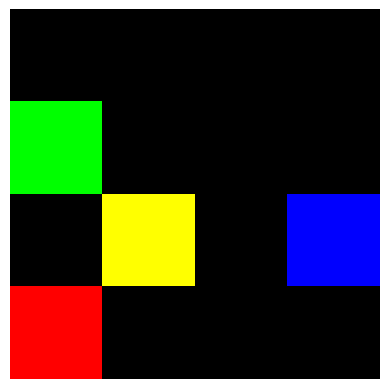

Step: 14


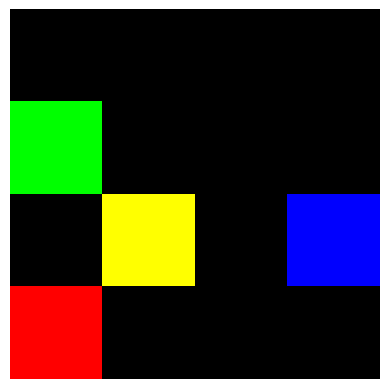

Step: 15


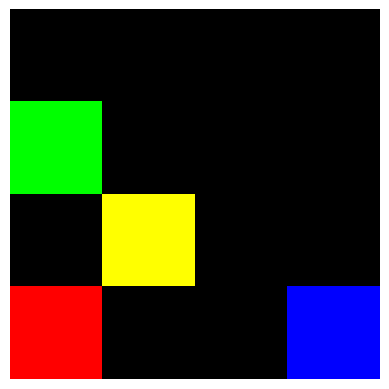

Game Result: Loss


In [6]:
# Play 10 games
for game in range(10):
    env = CustomMiniGridEnv(grid_size=4)
    obs = env.reset()

    print("Game", game + 1)
    print("--------")

    done = False
    while not done:
        grid_img = env.get_observation()

        plt.imshow(grid_img)
        plt.axis('off')
        plt.show()
        
        action = env.action_space.sample()  # Random action
        obs, reward, done, _ = env.step(action)

        if done:
            if reward == 10:
                print("Game Result: Win")
            else:
                print("Game Result: Loss")
            break

        print("Step:", env.step_counter)

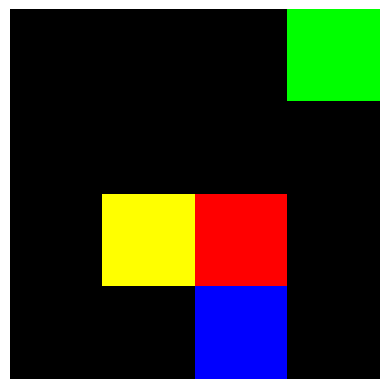

In [7]:
env = CustomMiniGridEnv(grid_size=4)
obs = env.reset()
grid_img = env.get_observation()

plt.imshow(grid_img)
plt.axis('off')
plt.show()

In [8]:
reward

-1

In [9]:
env = CustomMiniGridEnv(grid_size=4)
env.render_np()

array([[[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [1, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 1],
        [0, 0, 0, 0]]], dtype=uint8)

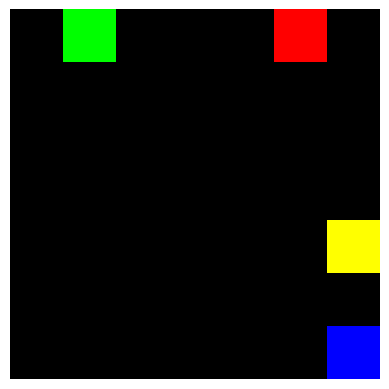

In [10]:
game = CustomMiniGridEnv(grid_size=7)
game.render()